In [1]:
import pandas
import datetime
import time
import feather
import numpy
from aacgmv2 import convert_mlt
from davitpy import utils
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
eventDate = datetime.datetime(2011,6,8)
timeStart = datetime.datetime(2011,6,8,4,0)
selTime = datetime.datetime(2011,6,8,4,30) 
timeEnd = datetime.datetime(2011,6,8,6,0)
plotMlatRange = [ 50., 70. ]
anlyzCoords = 'mlt'

In [3]:
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )



In [4]:
inpColList = [ "dateStr", "timeStr", "Mlat",\
              "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "../data/tec-medFilt-" + eventDate.strftime("%Y%m%d") + ".txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True,\
                                    header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply( convert_to_datetime, axis=1 )
medFiltTECDF["MLT"] = [ convert_mlt( mlon, ts , m2a=False ) \
                       for (mlon,ts) in zip(medFiltTECDF["Mlon"],\
                                            medFiltTECDF["date"]) ]
medFiltTECDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date,MLT
0,20110608,10,11.0,0.0,10.9,1.0,2.0,2011-06-08 00:10:00,19.597488
1,20110608,10,11.0,2.0,4.4,1.0,2.0,2011-06-08 00:10:00,19.730821
2,20110608,10,11.0,4.0,4.4,1.0,2.0,2011-06-08 00:10:00,19.864154
3,20110608,10,11.0,6.0,7.4,1.0,2.0,2011-06-08 00:10:00,19.997488
4,20110608,10,11.0,8.0,9.2,1.0,2.0,2011-06-08 00:10:00,20.130821


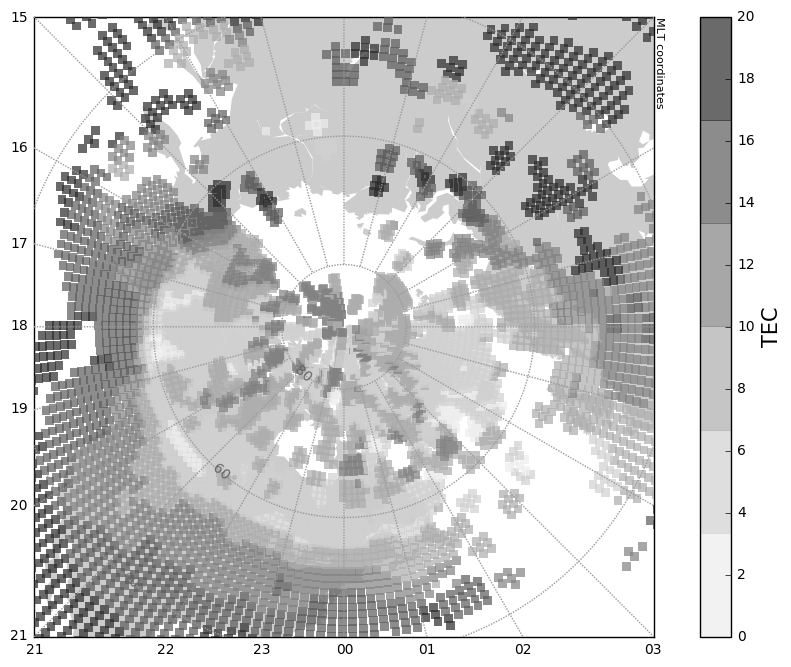

In [5]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Greys"))
selTecDF = medFiltTECDF[ medFiltTECDF["date"] == selTime ].reset_index(drop=True)

# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=40., gridLabels=True,\
                            coords=anlyzCoords, ax=ax, datetime=selTime, lon_0=0)
xVec, yVec = m1(selTecDF["MLT"].values*15, selTecDF["Mlat"].values, coords=anlyzCoords)

tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=20. )


cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)

In [6]:
# We'll get the min TEC at the trough
trghMinDF = medFiltTECDF[ ((medFiltTECDF["Mlat"] <= plotMlatRange[1]) &\
                       (medFiltTECDF["Mlat"] >= plotMlatRange[0])) ]
trghMinDF["MLTrnd"] = trghMinDF["MLT"].round()
trghMinTECDF = trghMinDF[ ["MLTrnd", "date", "med_tec"]\
                     ].groupby(["MLTrnd", "date"]).min().reset_index()
trghMinTECDF.columns = ["MLTrnd", "date", "min_tec"]
trghMinDF = pandas.merge( trghMinDF, trghMinTECDF,\
                         left_on=["MLTrnd", "date", "med_tec"],\
                        right_on=["MLTrnd", "date", "min_tec"])
# Now there could be multiple locations with min tec value
# get the median MLAT location in that case!!!
trghMinDF = trghMinDF[ [ "date", "Mlat",\
                        "med_tec", "min_tec", "MLTrnd" ] ]
trghMinDF = trghMinDF.groupby( [ "date", "med_tec", \
                        "min_tec", "MLTrnd" ] ).min().reset_index()
trghMinDF.head()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,date,med_tec,min_tec,MLTrnd,Mlat
0,2011-06-08 00:10:00,0.1,0.1,2.0,56.0
1,2011-06-08 00:10:00,0.4,0.4,24.0,70.0
2,2011-06-08 00:10:00,0.8,0.8,9.0,56.0
3,2011-06-08 00:10:00,1.1,1.1,0.0,67.0
4,2011-06-08 00:10:00,1.2,1.2,1.0,65.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                   date  med_tec  min_tec  MLTrnd  Mlat
906 2011-06-08 04:05:00      2.8      2.8    20.0  60.0


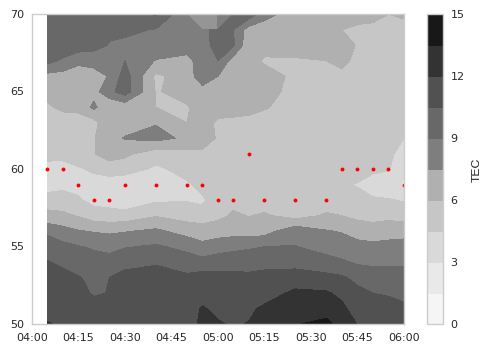

In [28]:
# Some temp constants
plotMltChsn = 20
nrstMLTCutoff = 0.1
plotmed_tecCutoff = 0.0
ticks = numpy.linspace(0,15,11)
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plotting
seaMap = ListedColormap(sns.color_palette("Greys",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = medFiltTECDF[ ((medFiltTECDF["date"] >= timeStart) &\
                       (medFiltTECDF["date"] <= timeEnd) &\
                    (medFiltTECDF["Mlat"] <= plotMlatRange[1]) &\
                       (medFiltTECDF["Mlat"] >= plotMlatRange[0]) )]

# Now we don't have exact MLT
# so we'll get mean TEC values
# by rounding MLTs to nearest int
# selDF = selDF[ numpy.abs( selDF["MLT"] - plotMltChsn ) <= nrstMLTCutoff ].reset_index(drop=True)
selDF["MLTRnd"] = selDF["MLT"].round()
selDF = selDF[ selDF["MLTRnd"] == plotMltChsn ]
selDF["time"] = [ date2num(x) for x in selDF["date"] ]
selDF = selDF[ ["Mlat", "time", "med_tec"]\
             ].groupby( ["Mlat", "time"] ).median().reset_index()

plotmedFiltTECDF = selDF[ ["Mlat", "time",\
                        "med_tec"] ].pivot( "Mlat", "time" )


mlatVals = plotmedFiltTECDF.index.values
timeVals = plotmedFiltTECDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
ampPlot = ax.pcolormesh(timeCntr, mlatCntr,med_tecVals.T,cmap=seaMap)
ampPlot = ax.contourf(timeCntr, mlatCntr,med_tecVals.T, ticks,cmap=seaMap)
# ax.contour(timeCntr, mlatCntr,med_tecVals.T, numpy.linspace(0,10,9),
#                  origin='lower',
#                  linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label("TEC")

selMinDF = trghMinDF[ ((trghMinDF["MLTrnd"] == plotMltChsn) &\
                       (trghMinDF["date"] >= timeStart) &\
                      (trghMinDF["date"] <= timeEnd) ) ]
ax.plot( selMinDF["date"].values, selMinDF["Mlat"].values, 'r.' )

print selMinDF[ selMinDF["date"] == timeStart + datetime.timedelta(minutes=5) ]

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data

fig.savefig( "../plots/tec-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

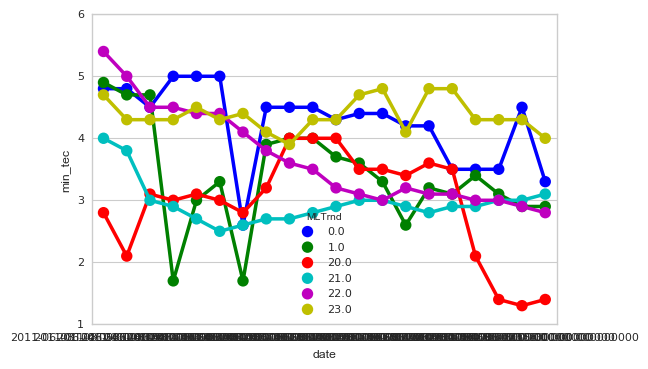

In [32]:
sns.set_style("whitegrid")
sns.set_context("paper")


selMinDF = trghMinDF[trghMinDF["MLTrnd"].isin([20, 21, 22, 23, 0, 1])]
selMinDF = selMinDF[ (selMinDF["date"] >= timeStart) & (selMinDF["date"] <= timeEnd) ]
fig = plt.figure()
ax = fig.add_subplot(111)

sns.pointplot( x="date", y="min_tec", hue="MLTrnd", data=selMinDF, ax=ax )
# ax.plot( selMinDF["date"].values, selMinDF["min_tec"].values )

# ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# ax.set_xlim( [timeStart, timeEnd] )

In [12]:
medFiltTECDF["MLTRnd"] = medFiltTECDF["MLT"].round()
xx = medFiltTECDF[ (medFiltTECDF["date"] == timeStart + datetime.timedelta(minutes=5)) &\
                  (medFiltTECDF["MLTRnd"] == 21) &\
                  (medFiltTECDF["Mlat"] <= 65) &\
                       (medFiltTECDF["Mlat"] >= 55)]
xx["med_tec"].min()

4.0

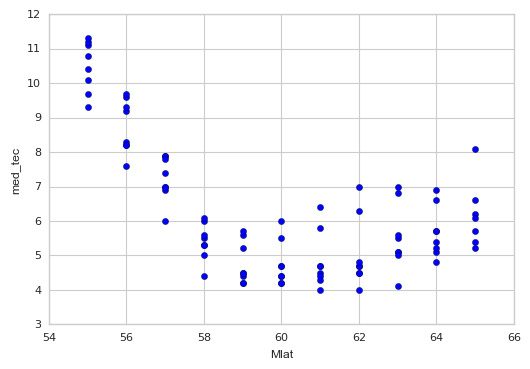

In [13]:
xx.plot( x="Mlat", y="med_tec", kind="scatter" )